# Import libraries

In [1]:
import pandas as pd
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

import numpy as np

import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

<ipython-input-1-be0b91895dfb>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Download Yahoo data

In [2]:
ethdf = yf.download('ETH-USD', start='2019-01-01', end='2023-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
ethdf

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01 00:00:00+00:00,133.418152,141.397507,132.650711,140.819412,140.819412,2258709868
2019-01-02 00:00:00+00:00,141.519516,156.929138,140.650955,155.047684,155.047684,3328240369
2019-01-03 00:00:00+00:00,155.196045,155.863052,147.198364,149.135010,149.135010,2676164880
2019-01-04 00:00:00+00:00,148.912888,156.878983,147.907104,154.581940,154.581940,3126192535
2019-01-05 00:00:00+00:00,154.337418,160.824890,154.337418,155.638596,155.638596,3338211928
...,...,...,...,...,...,...
2022-12-27 00:00:00+00:00,1226.987061,1230.418091,1205.895630,1212.791626,1212.791626,4091530737
2022-12-28 00:00:00+00:00,1212.736572,1213.128906,1185.702148,1189.986084,1189.986084,4991669631
2022-12-29 00:00:00+00:00,1190.010132,1204.141602,1188.360229,1201.595337,1201.595337,4132233940


# Import & Explore tweets with VADER sentiment score

In [4]:
df = pd.read_pickle('ETH_sent.pkl')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969417 entries, 0 to 1969416
Data columns (total 27 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   created_at                       object        
 1   edit_history_tweet_ids           object        
 2   author_id                        object        
 3   lang                             object        
 4   conversation_id                  object        
 5   text                             object        
 6   id                               object        
 7   reply_settings                   object        
 8   public_metrics.retweet_count     int64         
 9   public_metrics.reply_count       int64         
 10  public_metrics.like_count        int64         
 11  public_metrics.quote_count       int64         
 12  public_metrics.impression_count  int64         
 13  referenced_tweets                object        
 14  in_reply_to_user_id              o

In [6]:
df.columns

Index(['created_at', 'edit_history_tweet_ids', 'author_id', 'lang',
       'conversation_id', 'text', 'id', 'reply_settings',
       'public_metrics.retweet_count', 'public_metrics.reply_count',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'public_metrics.impression_count', 'referenced_tweets',
       'in_reply_to_user_id', 'geo.place_id', 'geo.coordinates.type',
       'geo.coordinates.coordinates', 'withheld.copyright',
       'withheld.country_codes', 'withheld.scope', 'time', 'clean_tweets',
       'neg', 'neu', 'pos', 'compound'],
      dtype='object')

In [7]:
print(f'Ethereum sentiment mean for the period: {df.compound.mean()}')

Ethereum sentiment mean for the period: 0.1825044641129837


In [8]:
collist = ['compound', 'clean_tweets', 'time']

In [9]:
df = df.set_index('time')

In [10]:
# Calculate the average sentiment for each day

means = df.groupby(pd.Grouper(freq='1D')).mean()

<ipython-input-10-fa723974454a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = df.groupby(pd.Grouper(freq='1D')).mean()


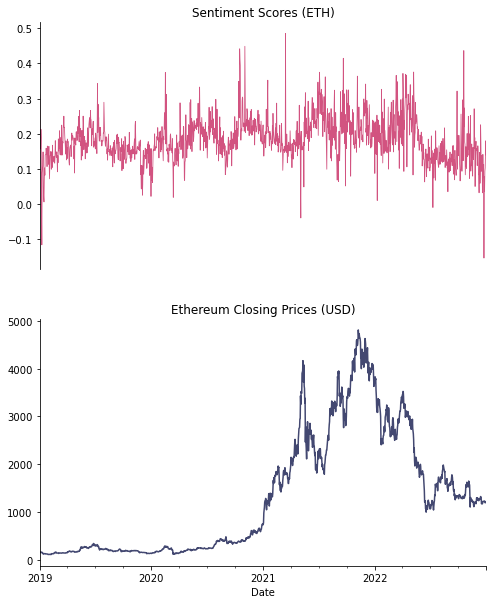

In [12]:
# Plot results
fig, ax = plt.subplots(figsize=(8, 10), nrows=2)

means.compound.plot(ax=ax[0], color='#D25380', linewidth=0.8)

ax[0].spines[[ 'top', 'right', 'bottom']].set_visible(False)

ax[0].set_title('Sentiment Scores (ETH)')

ax[0].axes.get_xaxis().set_visible(False)


# Prices

ethdf[['Adj Close']].plot(color='#434871', ax=ax[1])

ax[1].legend().set_visible(False)

ax[1].spines[[ 'top', 'right']].set_visible(False)

ax[1].set_title('Ethereum Closing Prices (USD)');

#plt.savefig('Ethereum.png', dpi=300, facecolor='white',bbox_inches='tight' );

# Augmented Dickey Fuller test - stationarity

In [13]:
result = adfuller(means['compound'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

Test Statistics: -3.6169324206775344
p-value: 0.005445446202998058
critical_values: {'1%': -3.4348929812602784, '5%': -2.863546418485167, '10%': -2.5678382024888378}
Series is stationary


In [14]:
result1 = adfuller(ethdf['Adj Close'])
print(f'Test Statistics: {result1[0]}')
print(f'p-value: {result1[1]}')
print(f'critical_values: {result1[4]}')
if result1[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

Test Statistics: -1.3896350950139478
p-value: 0.5872349735947685
critical_values: {'1%': -3.434889827343955, '5%': -2.863545026607168, '10%': -2.5678374612882515}
Series is not stationary


In [15]:
ethdf[['transformed']] = ethdf[['Adj Close']].diff()

In [16]:
# Calculate the log returns

ethdf['logret'] = np.log1p(ethdf[['Adj Close']].pct_change())

In [17]:
result2 = adfuller(ethdf['transformed'].dropna())
print(f'Test Statistics: {result2[0]}')
print(f'p-value: {result2[1]}')
print(f'critical_values: {result2[4]}')
if result2[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

Test Statistics: -9.601879988840484
p-value: 1.9109311638496249e-16
critical_values: {'1%': -3.434889827343955, '5%': -2.863545026607168, '10%': -2.5678374612882515}
Series is stationary


In [18]:
result3 = adfuller(ethdf['logret'].dropna())
print(f'Test Statistics: {result3[0]}')
print(f'p-value: {result3[1]}')
print(f'critical_values: {result3[4]}')
if result3[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

Test Statistics: -11.42404054702981
p-value: 6.763610406213626e-21
critical_values: {'1%': -3.4348678719530934, '5%': -2.863535337271721, '10%': -2.5678323015457787}
Series is stationary


# Transform data for further analysis

In [19]:
ethdf = ethdf.tz_localize(None)

In [20]:
mergedf = pd.merge_ordered(ethdf, means, left_on=ethdf.index, right_on=means.index)

In [21]:
mergedf

,key_0,Open,High,Low,Close,Adj Close,Volume,transformed,logret,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,public_metrics.impression_count,neg,neu,pos,compound
0,2019-01-01,133.418152,141.397507,132.650711,140.819412,140.819412,2258709868,NaN,NaN,0.536208,0.161920,1.847030,0.084622,0.000000,0.023793,0.842407,0.133793,0.312475
1,2019-01-02,141.519516,156.929138,140.650955,155.047684,155.047684,3328240369,14.228271,0.096254,0.797183,0.497183,3.096479,0.129577,0.000000,0.024786,0.869537,0.105675,0.209722
2,2019-01-03,155.196045,155.863052,147.198364,149.135010,149.135010,2676164880,-5.912674,-0.038881,1.133380,1.786313,3.666899,0.175279,0.000000,0.049217,0.843096,0.107677,0.193104
3,2019-01-04,148.912888,156.878983,147.907104,154.581940,154.581940,3126192535,5.446930,0.035872,1.023338,0.328147,2.881895,0.099010,0.000000,0.037755,0.871862,0.090369,0.156892
4,2019-01-05,154.337418,160.824890,154.337418,155.638596,155.638596,3338211928,1.056656,0.006812,0.630769,0.243357,2.046853,0.119580,0.000000,0.038029,0.853272,0.108684,0.212567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2022-12-27,1226.987061,1230.418091,1205.895630,1212.791626,1212.791626,4091530737,-14.182739,-0.011626,0.408191,0.308532,2.368601,0.081229,233.391809,0.026633,0.920326,0.053045,0.093291
1457,2022-12-28,1212.736572,1213.128906,1185.702148,1189.986084,1189.986084,4991669631,-22.805542,-0.018983,0.303956,0.199861,1.904927,0.124219,155.055517,0.013990,0.937352,0.048659,0.103310
1458,2022-12-29,1190.010132,1204.141602,1188.360229,1201.595337,1201.595337,4132233940,11.609253,0.009709,0.129555,1.192982,1.029015,0.031714,116.923752,0.034654,0.881471,0.083882,0.147959
1459,2022-12-30,1201.569580,1202.034668,1187.462524,1199.232788,1199.232788,4055668253,-2.362549,-0.001968,0.139172,0.671419,0.803123,0.029192,57.758995,0.034481,0.876810,0.088715,0.179949


In [22]:
mergedf[['transformed', 'compound', 'logret']].dropna()

,transformed,compound,logret
1,14.228271,0.209722,0.096254
2,-5.912674,0.193104,-0.038881
3,5.446930,0.156892,0.035872
4,1.056656,0.212567,0.006812
5,2.107605,0.189522,0.013451
...,...,...,...
1456,-14.182739,0.093291,-0.011626
1457,-22.805542,0.103310,-0.018983
1458,11.609253,0.147959,0.009709
1459,-2.362549,0.179949,-0.001968


# VAR model

In [23]:
model = VAR(mergedf[['Adj Close', 'compound']].dropna())

x = model.select_order(maxlags=20)
x.summary()


,AIC,BIC,FPE,HQIC
0,8.629,8.637,5594.,8.632
1,2.953,2.975,19.17,2.962
2,2.891,2.927,18.00,2.904
3,2.863,2.914*,17.51,2.882
4,2.849,2.915,17.27,2.874
5,2.843,2.924,17.17,2.873
6,2.837,2.932,17.06,2.872
7,2.830,2.940,16.95,2.871*
8,2.830,2.955,16.95,2.877
9,2.834,2.973,17.02,2.886


In [24]:
model_fitted = model.fit(18)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, Jun, 2023
Time:                     14:02:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.08881
Nobs:                     1443.00    HQIC:                   2.91928
Log likelihood:          -6054.48    FPE:                    16.7491
AIC:                      2.81832    Det(Omega_mle):         15.9221
--------------------------------------------------------------------
Results for equation Adj Close
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -6.442358        10.769247           -0.598           0.550
L1.Adj Close          0.945215         0.026658           35.457           0.000
L1.compound         -17.210326        50.029787         

# Portmentau and Durbin Watson tests

In [25]:
Portmentau = model_fitted.test_whiteness(nlags=20)
Portmentau.summary()

Test statistic,Critical value,p-value,df
13.62,15.51,0.092,8


In [26]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(mergedf[['Adj Close', 'compound']].dropna().columns, out):
    print(col, ':', round(val, 7))

Adj Close : 1.9995378
compound : 2.0000005


# Johansen test

In [27]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

jres = coint_johansen(mergedf[['logret', 'compound']].dropna(), det_order=0, k_ar_diff=20)

In [28]:
print(f'Maximum eigenvalue statistic : {jres.max_eig_stat}' )
print(f'Critical values (90%, 95%, 99%) of maximum eigenvalue statistic.: {jres.max_eig_stat_crit_vals}')

Maximum eigenvalue statistic : [67.25039578 13.15387281]
Critical values (90%, 95%, 99%) of maximum eigenvalue statistic.: [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [29]:
print(f'Eigenvalues of VECM coefficient matrix : {jres.eig}' )
print(f'Eigenvectors of VECM coefficient matrix : {jres.evec}' )

Eigenvalues of VECM coefficient matrix : [0.04565889 0.00909933]
Eigenvectors of VECM coefficient matrix : [[91.14037471  2.77375666]
 [-3.84283148 24.89111564]]


# Granger Causality test

In [30]:
grangercausalitytests(mergedf[['transformed', 'compound']].dropna(), maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0816  , p=0.7752  , df_denom=1456, df_num=1
ssr based chi2 test:   chi2=0.0817  , p=0.7750  , df=1
likelihood ratio test: chi2=0.0817  , p=0.7750  , df=1
parameter F test:         F=0.0816  , p=0.7752  , df_denom=1456, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5572  , p=0.5729  , df_denom=1453, df_num=2
ssr based chi2 test:   chi2=1.1183  , p=0.5717  , df=2
likelihood ratio test: chi2=1.1179  , p=0.5718  , df=2
parameter F test:         F=0.5572  , p=0.5729  , df_denom=1453, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8558  , p=0.4635  , df_denom=1450, df_num=3
ssr based chi2 test:   chi2=2.5799  , p=0.4610  , df=3
likelihood ratio test: chi2=2.5776  , p=0.4614  , df=3
parameter F test:         F=0.8558  , p=0.4635  , df_denom=1450, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6842  , p=0.

{1: ({'ssr_ftest': (0.08156653418149275, 0.7752262343107712, 1456.0, 1),
   'ssr_chi2test': (0.08173459709532825, 0.7749603570599578, 1),
   'lrtest': (0.0817323077499168, 0.7749634237739393, 1),
   'params_ftest': (0.08156653418144462, 0.7752262343107712, 1456.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.557243473915148, 0.5729081491025834, 1453.0, 2),
   'ssr_chi2test': (1.118322071532396, 0.5716884889055245, 2),
   'lrtest': (1.117893400369212, 0.5718110352228325, 2),
   'params_ftest': (0.557243473915244, 0.5729081491024909, 1453.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.8558260544537676, 0.4634651027249663, 1450.0, 3),
   'ssr_chi2test': (2.579872885529254, 0.4610290208837913, 3),
   'lrtest': (2.577591520479473, 0.4614315927216702, 3),
   'params_ftest': (0.8558260544537847, 0.4634651027249663, 1450.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

In [31]:
grangercausalitytests(mergedf[['compound', 'transformed']].dropna(), maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1216  , p=0.7274  , df_denom=1456, df_num=1
ssr based chi2 test:   chi2=0.1219  , p=0.7270  , df=1
likelihood ratio test: chi2=0.1218  , p=0.7270  , df=1
parameter F test:         F=0.1216  , p=0.7274  , df_denom=1456, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0079  , p=0.3653  , df_denom=1453, df_num=2
ssr based chi2 test:   chi2=2.0227  , p=0.3637  , df=2
likelihood ratio test: chi2=2.0213  , p=0.3640  , df=2
parameter F test:         F=1.0079  , p=0.3653  , df_denom=1453, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0614  , p=0.3644  , df_denom=1450, df_num=3
ssr based chi2 test:   chi2=3.1996  , p=0.3619  , df=3
likelihood ratio test: chi2=3.1960  , p=0.3624  , df=3
parameter F test:         F=1.0614  , p=0.3644  , df_denom=1450, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9398  , p=0.

{1: ({'ssr_ftest': (0.1216023537902205, 0.7273534814651768, 1456.0, 1),
   'ssr_chi2test': (0.12185290809061243, 0.7270334858123686, 1),
   'lrtest': (0.12184781991163618, 0.7270389572261404, 1),
   'params_ftest': (0.12160235379139159, 0.7273534814639586, 1456.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.0078608709639572, 0.3652539467177327, 1453.0, 2),
   'ssr_chi2test': (2.022658155355058, 0.3637352258004222, 2),
   'lrtest': (2.0212564522607863, 0.363990239549124, 2),
   'params_ftest': (1.007860870964487, 0.36525394671753164, 1453.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.0613947615888046, 0.3644370871276813, 1450.0, 3),
   'ssr_chi2test': (3.1995562088997684, 0.36186897529617795, 3),
   'lrtest': (3.1960482482118096, 0.36237479607786804, 3),
   'params_ftest': (1.0613947615880337, 0.36443708712799616, 1450.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.

In [32]:
grangercausalitytests(mergedf[['compound', 'logret']].dropna(), maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2999  , p=0.2544  , df_denom=1456, df_num=1
ssr based chi2 test:   chi2=1.3026  , p=0.2537  , df=1
likelihood ratio test: chi2=1.3020  , p=0.2538  , df=1
parameter F test:         F=1.2999  , p=0.2544  , df_denom=1456, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8772  , p=0.4162  , df_denom=1453, df_num=2
ssr based chi2 test:   chi2=1.7604  , p=0.4147  , df=2
likelihood ratio test: chi2=1.7594  , p=0.4149  , df=2
parameter F test:         F=0.8772  , p=0.4162  , df_denom=1453, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5102  , p=0.6753  , df_denom=1450, df_num=3
ssr based chi2 test:   chi2=1.5379  , p=0.6735  , df=3
likelihood ratio test: chi2=1.5371  , p=0.6737  , df=3
parameter F test:         F=0.5102  , p=0.6753  , df_denom=1450, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3531  , p=0.

{1: ({'ssr_ftest': (1.299915564672148, 0.2544161620078955, 1456.0, 1),
   'ssr_chi2test': (1.3025939621268297, 0.2537399496899383, 1),
   'lrtest': (1.3020128305979597, 0.2538458840469284, 1),
   'params_ftest': (1.2999155646724243, 0.2544161620078354, 1456.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.8771999700857576, 0.41616610150260636, 1453.0, 2),
   'ssr_chi2test': (1.7604371044529037, 0.41469226985808616, 2),
   'lrtest': (1.7593751543899998, 0.41491251956749053, 2),
   'params_ftest': (0.8771999700859318, 0.41616610150250544, 1453.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.5101779797487641, 0.6753055238724464, 1450.0, 3),
   'ssr_chi2test': (1.5379227237805846, 0.6735458452895642, 3),
   'lrtest': (1.5371116245223675, 0.6737318510710903, 3),
   'params_ftest': (0.510177979748862, 0.6753055238723351, 1450.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

In [33]:
grangercausalitytests(mergedf[['logret', 'compound']].dropna(), maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7094  , p=0.3998  , df_denom=1456, df_num=1
ssr based chi2 test:   chi2=0.7108  , p=0.3992  , df=1
likelihood ratio test: chi2=0.7107  , p=0.3992  , df=1
parameter F test:         F=0.7094  , p=0.3998  , df_denom=1456, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4999  , p=0.6067  , df_denom=1453, df_num=2
ssr based chi2 test:   chi2=1.0032  , p=0.6056  , df=2
likelihood ratio test: chi2=1.0029  , p=0.6057  , df=2
parameter F test:         F=0.4999  , p=0.6067  , df_denom=1453, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4433  , p=0.7221  , df_denom=1450, df_num=3
ssr based chi2 test:   chi2=1.3363  , p=0.7205  , df=3
likelihood ratio test: chi2=1.3356  , p=0.7207  , df=3
parameter F test:         F=0.4433  , p=0.7221  , df_denom=1450, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2929  , p=0.

{1: ({'ssr_ftest': (0.7093719954288913, 0.3997906942249705, 1456.0, 1),
   'ssr_chi2test': (0.710833613551341, 0.3991672112433441, 1),
   'lrtest': (0.7106605085609772, 0.39922462624156074, 1),
   'params_ftest': (0.7093719954291134, 0.3997906942248628, 1456.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.4998795609373919, 0.6067079958626346, 1453.0, 2),
   'ssr_chi2test': (1.0031994492040157, 0.6055611533727476, 2),
   'lrtest': (1.0028544739907375, 0.6056656141756046, 2),
   'params_ftest': (0.4998795609374038, 0.6067079958626346, 1453.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.4432802114650028, 0.7220954031583717, 1450.0, 3),
   'ssr_chi2test': (1.3362605546989845, 0.7205411839925373, 3),
   'lrtest': (1.3356481657938275, 0.720685972598057, 3),
   'params_ftest': (0.4432802114650512, 0.7220954031582958, 1450.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.,

In [34]:
# Summarize Granger Causality

from statsmodels.tsa.stattools import grangercausalitytests

maxlag=18
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(mergedf[['transformed', 'compound', 'logret']].dropna(), variables = mergedf[['transformed', 'compound', 'logret']].dropna().columns)

,transformed_x,compound_x,logret_x
transformed_y,1.0000,0.1258,0.6048
compound_y,0.0257,1.0000,0.2537
logret_y,0.0561,0.3992,1.0000


In [35]:
#Check correlation

mergedf[['compound', 'logret', 'Adj Close']].corr()

,compound,logret,Adj Close
compound,1.000000,0.008347,0.255407
logret,0.008347,1.000000,0.005947
Adj Close,0.255407,0.005947,1.000000


In [36]:
# Create descriptive statistics

mergedf.describe()

,Open,High,Low,Close,Adj Close,Volume,transformed,logret,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count,public_metrics.impression_count,neg,neu,pos,compound
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1.461000e+03,1460.000000,1460.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,1312.588731,1353.903535,1265.872924,1313.076391,1313.076391,1.594850e+10,0.723255,0.001466,1.084650,0.668085,4.402768,0.216251,2.639658,0.032439,0.870462,0.097097,0.183608
std,1281.822150,1320.929916,1236.268561,1280.902420,1280.902420,1.036689e+10,87.472040,0.049269,0.687269,0.751350,2.384313,0.228890,33.465183,0.011649,0.024720,0.022663,0.061374
min,104.645050,106.058876,95.184303,104.535301,104.535301,2.212109e+09,-919.390869,-0.550732,0.129555,0.081981,0.648164,0.013664,0.000000,0.004284,0.669325,0.020434,-0.152912
25%,202.955399,210.595078,198.064499,204.055786,204.055786,8.429099e+09,-12.469933,-0.020302,0.701567,0.361741,2.878582,0.099432,0.000000,0.025791,0.857458,0.082882,0.148091
50%,731.472839,754.299438,719.792236,737.803406,737.803406,1.395173e+10,0.424896,0.001351,0.939547,0.540746,3.852385,0.147541,0.000000,0.030220,0.872447,0.094109,0.177640
75%,2161.939453,2274.397461,2081.923584,2160.768311,2160.768311,2.023571e+10,16.346497,0.026503,1.255714,0.767790,5.318111,0.260703,0.000000,0.036547,0.885868,0.107856,0.217357
max,4810.071289,4891.704590,4718.039062,4812.087402,4812.087402,8.448291e+10,534.011230,0.230695,7.697037,18.011236,25.106618,3.605528,951.682784,0.150145,0.973875,0.312419,0.484791
